In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns
import scipy
import pylab

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer

from collections import defaultdict

# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division

%matplotlib inline
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')
pylab.rcParams.update({'figure.autolayout': True})

In [4]:
file_dir = '/Volumes/1TB_BAY/yelp_dataset_challenge_academic_dataset/'

#r = pd.read_csv(file_dir + 'review_without_text_year.csv')
r = pd.read_csv(file_dir + 'review_with_text.csv')
b = pd.read_csv('yelp_business_with_neighborhood.csv')
s = pd.read_csv('static_stats.csv')
u = pd.read_csv(file_dir + 'yelp_academic_dataset_user.csv')

/Users/Franklin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [133]:
rt = r.head(10000)

In [134]:
def WordCount(corpus, keyword):
    count = 0 #start the counter at 0
    for word in corpus.split(): #for each word in the corpus
        if word == keyword: #if the word is the keyword
            count = count + 1 #add one to the counter
    return count

def WordFreq(corpus, keyword):
    count = 0 #start the counter at 0
    for word in corpus.split(): #for each word in the corpus
        if word == keyword: #if the word is the keyword
            count = count + 1 #add one to the counter
    return count/len(corpus.split())

In [137]:
keyword = 'employee'

rt['kw_count'] =  rt['text'].apply(WordCount, args = (keyword,))
rt['kw_freq'] =  rt['text'].apply(WordFreq, args = (keyword,))
rt['kw'] = keyword

/Users/Franklin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Franklin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Franklin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

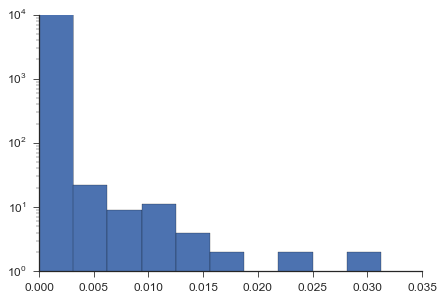

In [139]:
plt.hist(rt['kw_freq'])
plt.yscale('log')
sns.despine()

In [50]:
# Count
train_data_features = vectorizer.fit_transform(text)
vocab = vectorizer.get_feature_names()

# Sum up the counts of each vocabulary word
dist = list(np.sum(train_data_features.toarray(), axis=0))

pd.DataFrame([vocab, dist])

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,30,70s,after,ago,all,alternative,an,and,are,area,...,their,throwback,to,usually,very,voted,walking,which,while,year
1,1,1,1,1,1,1,1,2,2,1,...,1,1,2,1,1,1,1,1,1,2


In [ ]:
if any(word in all_text for word in keyword_list)